In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import dlib

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from joblib import dump, load

In [2]:
# Rutas a los modelos y datos
model_paths = {
    'predictor_path': "../modelos/shape_predictor_68_face_landmarks.dat",
    'face_rec_model_path': "../modelos/dlib_face_recognition_resnet_model_v1.dat",
}
base_path = '../imagenes/base_15k/'

In [3]:

# Cargar modelos de dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_paths['predictor_path'])
face_rec_model = dlib.face_recognition_model_v1(model_paths['face_rec_model_path'])

In [4]:


def plot_color_histogram(img_in, bins=40):
    # Asumir que img_in es un objeto de imagen PIL, no se necesita copiar ya que no la modificaremos
    img = img_in
    
    # Convertir la imagen en un array de numpy y normalizar los valores de los píxeles
    image_array = np.array(img) / 255.0
    
    # Crear una figura y un conjunto de subgráficos
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 3 gráficos, uno para cada canal RGB

    # Calcular y graficar los histogramas para cada canal
    for ax, color, channel in zip(axes, 'RGB', range(3)):
        histogram, bin_edges = np.histogram(
            image_array[:, :, channel], bins=bins, range=(0, 1)
        )
        
        # Normalizar el histograma (para que sume 1)
        histogram = histogram / histogram.sum()

        # Graficar el histograma en el eje correspondiente
        ax.bar(bin_edges[:-1], histogram, width=1/bins, color=color.lower())
        ax.set_title(f'Histograma para el canal {color}')
        ax.set_xlabel('Valor del pixel normalizado')
        ax.set_ylabel('Frecuencia Normalizada')
        ax.set_xlim([0, 1])
        ax.grid(axis='y', alpha=0.75)

    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()


In [5]:

def plot_max_difference_histogram(img_in, bins=40):
    # Asumir que img_in es un objeto de imagen PIL, usar directamente sin modificaciones
    img = img_in
    
    # Convertir la imagen completa en un array de numpy
    image_array = np.array(img)
    
    # Normalizar cada canal por su valor máximo
    max_values = image_array.max(axis=(0, 1))
    normalized_image_array = image_array / max_values

    # Calcular los histogramas porcentuales para cada canal
    histograms = np.zeros((3, bins))
    for channel in range(3):  # Para cada canal RGB
        histogram, _ = np.histogram(
            normalized_image_array[:, :, channel], bins=bins, range=(0, 1)
        )
        histograms[channel] = histogram / histogram.sum()  # Porcentaje de cada bin

    # Calcular las diferencias entre el valor porcentual de cada bin entre los tres canales
    max_differences = np.zeros(bins)
    for i in range(bins):
        max_differences[i] = max(histograms[:, i]) - min(histograms[:, i])

    # Graficar las diferencias máximas por bin
    plt.figure(figsize=(10, 5))  # Aumentar el ancho del gráfico a 10 pulgadas
    plt.bar(range(bins), max_differences, color='gray')
    plt.title('Diferencia máxima en cada bin entre canales')
    plt.xlabel('Bin')
    plt.ylabel('Diferencia máxima')
    plt.xticks(range(bins))
    plt.show()

    return max_differences



In [6]:
from PIL import Image
import numpy as np

def max_difference_histogram(img_in, bins=40):
    # Asumimos que img_in es un objeto de imagen PIL, usar directamente sin modificaciones
    img = img_in
    
    # Convertir la imagen completa en un array de numpy
    image_array = np.array(img)
    
    # Normalizar cada canal por su valor máximo
    max_values = image_array.max(axis=(0, 1))
    normalized_image_array = image_array / max_values

    # Calcular los histogramas porcentuales para cada canal
    histograms = np.zeros((3, bins))
    for channel in range(3):  # Para cada canal RGB
        histogram, _ = np.histogram(
            normalized_image_array[:, :, channel], bins=bins, range=(0, 1)
        )
        histograms[channel] = histogram / histogram.sum()  # Porcentaje de cada bin

    # Calcular las diferencias entre el valor porcentual de cada bin entre los tres canales
    max_differences = np.zeros(bins)
    for i in range(bins):
        max_differences[i] = max(histograms[:, i]) - min(histograms[:, i])

    return max_differences


In [7]:


def create_histogram_df(folder_path, label, bins=40):
    # Preparar la lista para almacenar los resultados
    results = []
    
    # Leer cada archivo de imagen en la carpeta especificada
    file_list = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    for file_name in tqdm(file_list, desc="Processing images"):
        # Construir la ruta completa al archivo de imagen
        file_path = os.path.join(folder_path, file_name)
        
        # Abrir la imagen
        img = Image.open(file_path)
        
        # Llamar a la función max_difference_histogram
        differences = max_difference_histogram(img, bins=bins)
        
        # Agregar los resultados a la lista, incluyendo el nombre del archivo y la etiqueta
        results.append([file_name] + differences.tolist() + [label])
    
    # Crear un DataFrame con los resultados
    column_names = ['foto'] + [f'bin_{i}' for i in range(bins)] + ['label']
    df = pd.DataFrame(results, columns=column_names)
    
    return df


In [8]:
demo_real = "./ID_REAL/ID/ID_REAL_0.png"
demo_FAKE_II = "./ID_FAKE_II/ID/ID_FAKE_II_0.png"
demo_FAKE_IV_A = "./ID_FAKE_IV/ID_A/ID_FAKE_IV_A_0.png"
demo_FAKE_IV_B = "./ID_FAKE_IV/ID_B/ID_FAKE_IV_B_0.png"

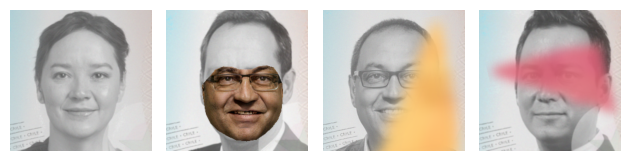

In [9]:
real = Image.open(demo_real)
fake_II = Image.open(demo_FAKE_II)
fake_IV_A = Image.open(demo_FAKE_IV_A)
fake_IV_B = Image.open(demo_FAKE_IV_B)

fig, axes = plt.subplots(1, 4) 

axes[0].imshow(real)
axes[0].axis('off')  

axes[1].imshow(fake_II)
axes[1].axis('off')

axes[2].imshow(fake_IV_A)
axes[2].axis('off')  

axes[3].imshow(fake_IV_B)
axes[3].axis('off')  


plt.tight_layout()
plt.show()

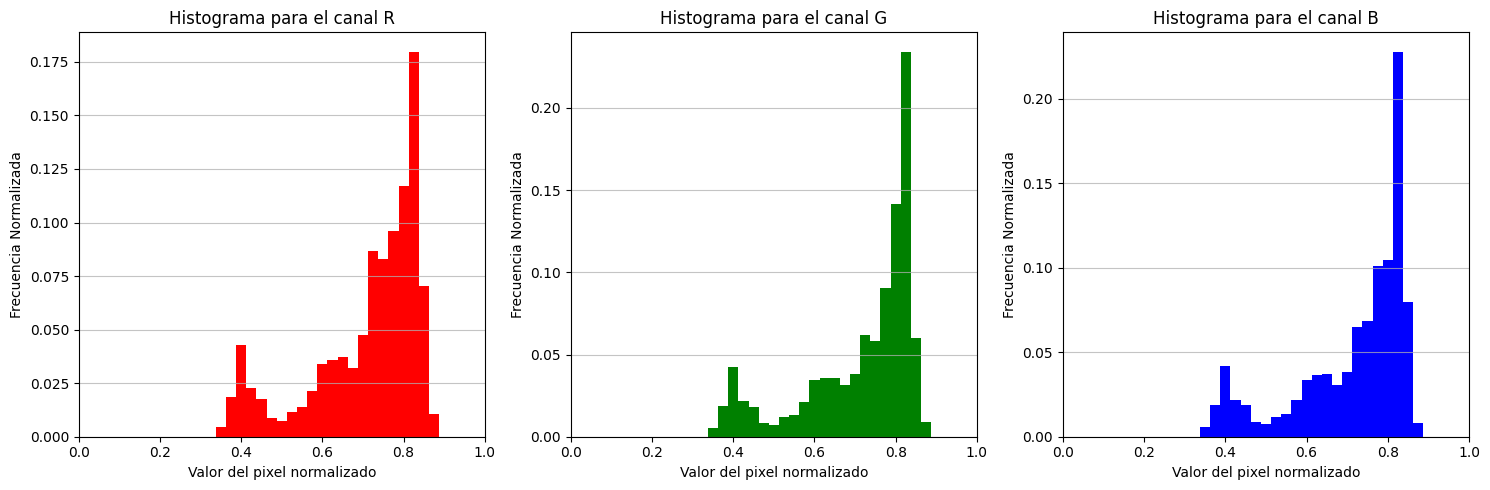

In [10]:
plot_color_histogram(real,40)

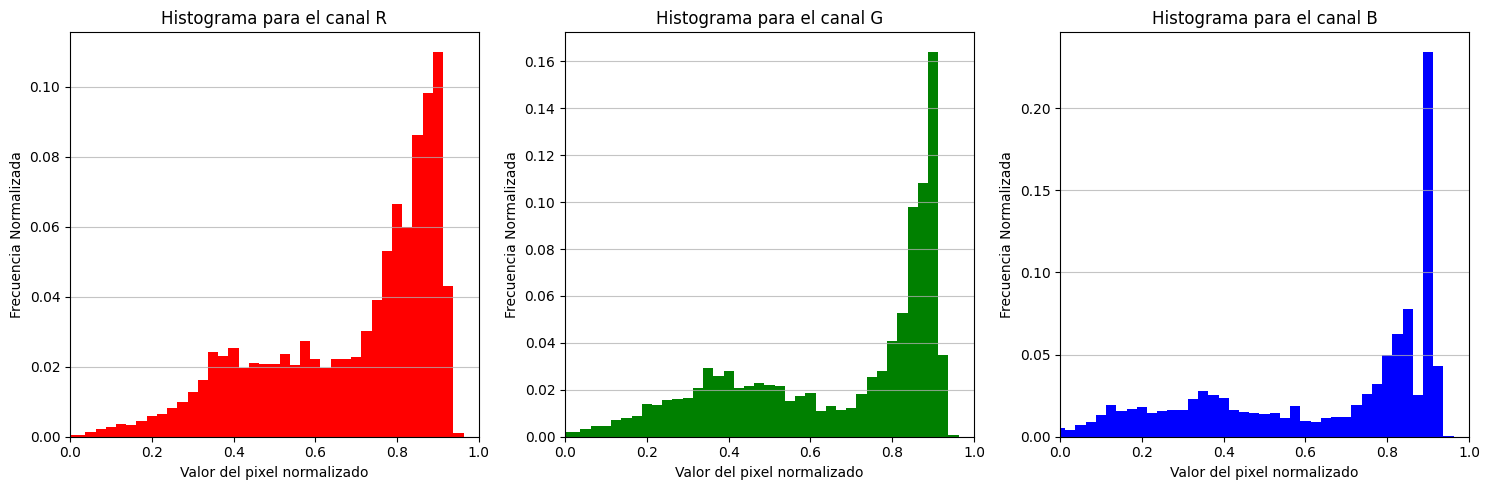

In [11]:
plot_color_histogram(fake_II,40)

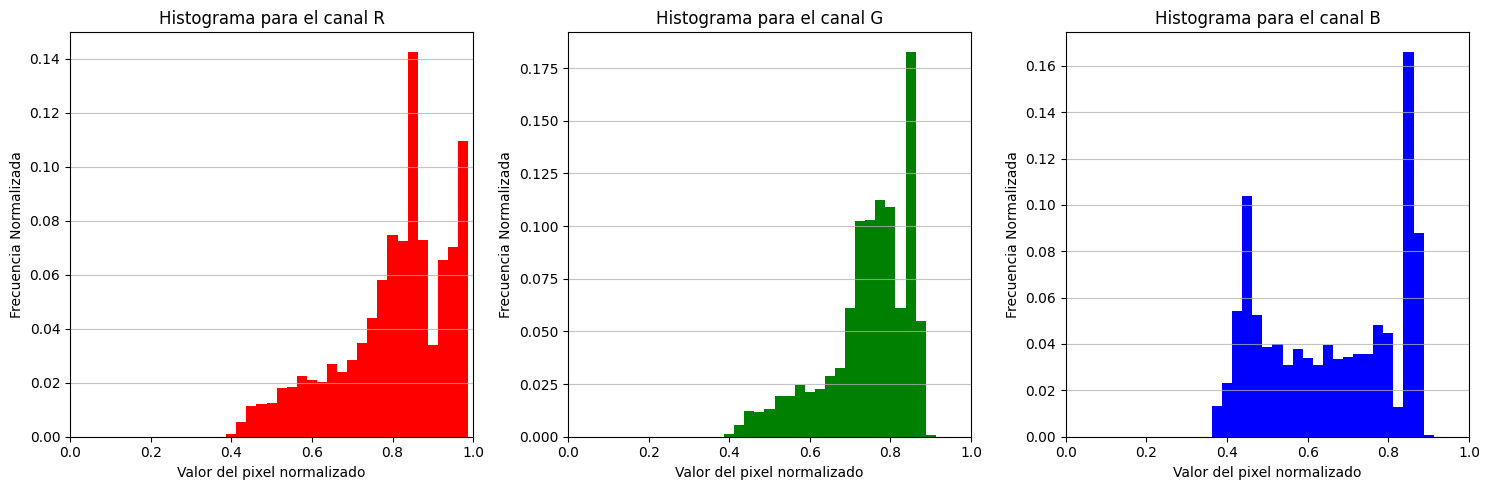

In [12]:
plot_color_histogram(fake_IV_A,40)

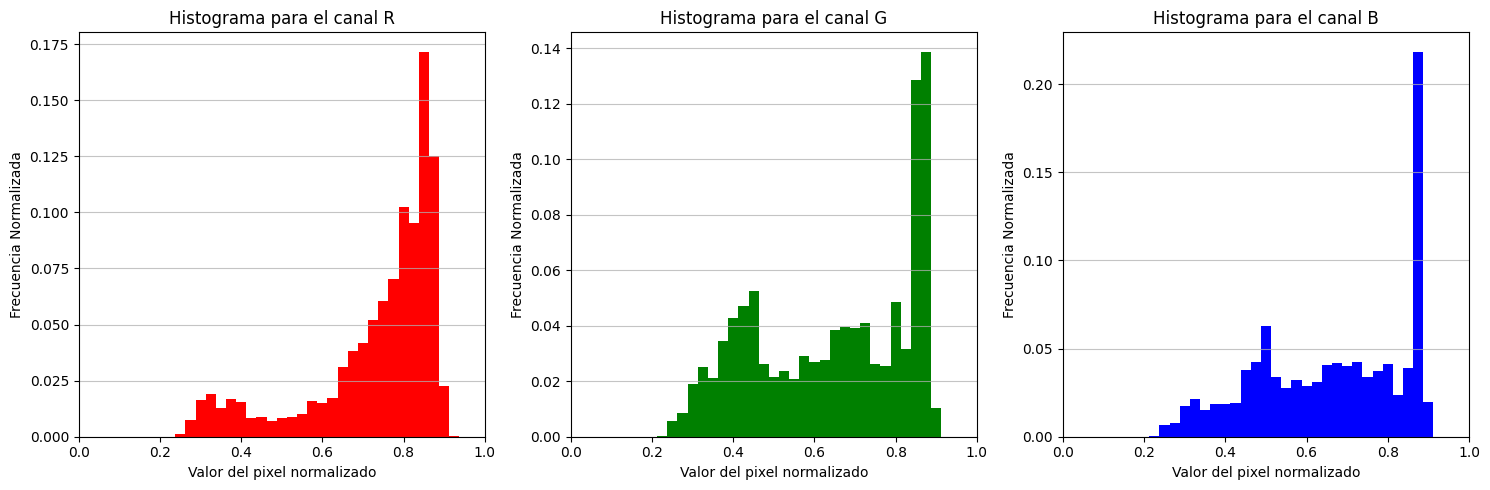

In [13]:
plot_color_histogram(fake_IV_B,40)

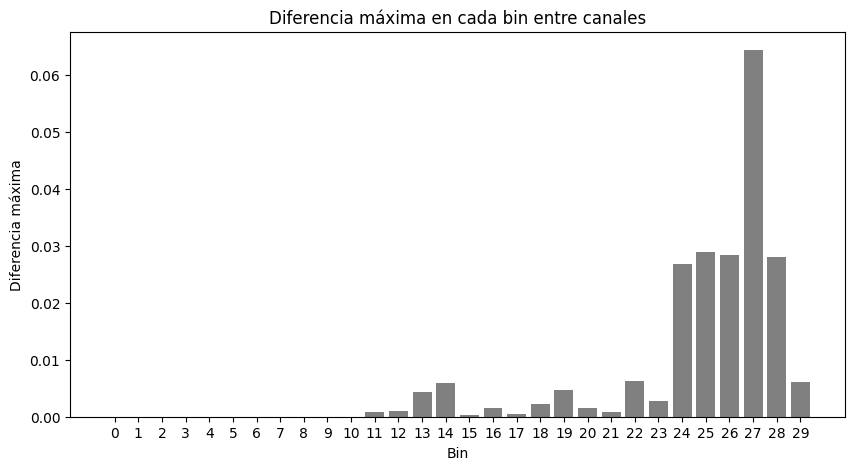

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00074768, 0.0010376 , 0.00434875, 0.00598145,
       0.0002594 , 0.00152588, 0.00041199, 0.00224304, 0.00469971,
       0.0015564 , 0.0007782 , 0.0063324 , 0.00274658, 0.02679443,
       0.02891541, 0.02842712, 0.06445312, 0.02807617, 0.00616455])

In [14]:
plot_max_difference_histogram(real,30)

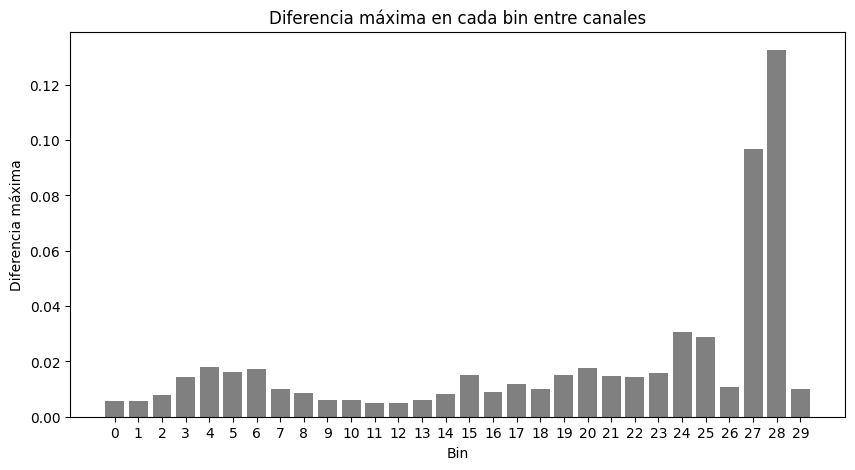

array([0.00579834, 0.00564575, 0.00793457, 0.01437378, 0.01797485,
       0.01599121, 0.0173645 , 0.00994873, 0.00845337, 0.00590515,
       0.00622559, 0.00509644, 0.00497437, 0.00588989, 0.00813293,
       0.01513672, 0.00901794, 0.01193237, 0.01017761, 0.01509094,
       0.0174408 , 0.01475525, 0.01441956, 0.01583862, 0.03063965,
       0.02868652, 0.01069641, 0.09686279, 0.1325531 , 0.01019287])

In [15]:
plot_max_difference_histogram(fake_II,30)

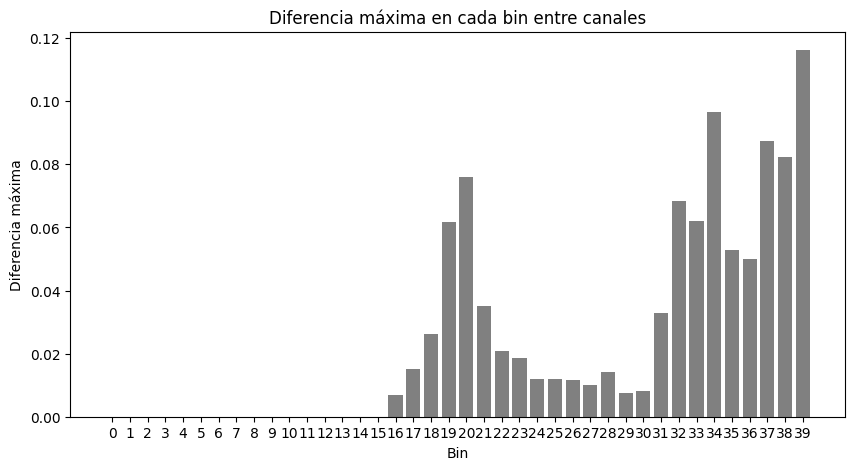

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00688171, 0.01516724, 0.02624512, 0.06173706,
       0.07592773, 0.03497314, 0.02093506, 0.01876831, 0.01184082,
       0.01202393, 0.01161194, 0.00991821, 0.01416016, 0.00759888,
       0.008255  , 0.03294373, 0.06846619, 0.06217957, 0.09671021,
       0.05282593, 0.05007935, 0.08732605, 0.08235168, 0.1162262 ])

In [16]:
plot_max_difference_histogram(fake_IV_A,40)

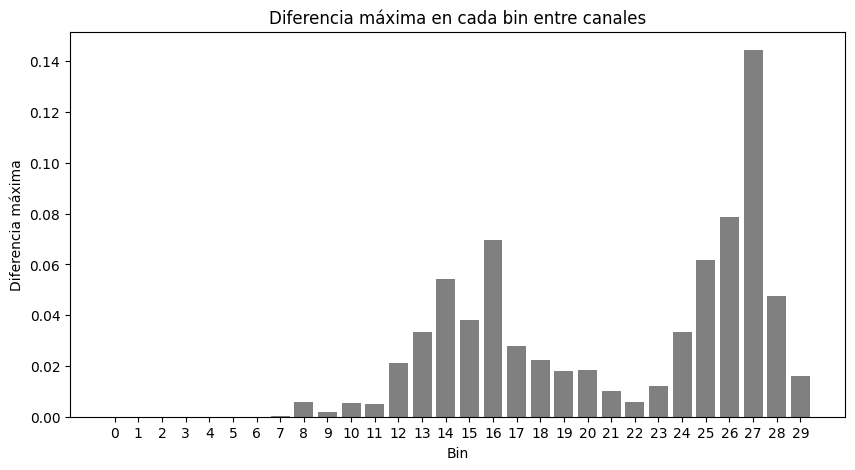

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0004425 , 0.00590515, 0.00190735,
       0.0052948 , 0.00515747, 0.02128601, 0.03340149, 0.05415344,
       0.03822327, 0.06958008, 0.02786255, 0.02249146, 0.01805115,
       0.01841736, 0.00999451, 0.00588989, 0.01217651, 0.03343201,
       0.06190491, 0.07861328, 0.14442444, 0.04748535, 0.0160675 ])

In [17]:
plot_max_difference_histogram(fake_IV_B,30)

In [18]:
path_destino_ID_REAL = "./ID_REAL/ID"
path_destino_VAL_REAL = "./ID_REAL/VAL"

path_destino_ID_FAKE_II = "./ID_FAKE_II/ID"
path_destino_VAL_FAKE_II = "./ID_FAKE_II/VAL"

path_destino_ID_FAKE_IV_A = "./ID_FAKE_IV/ID_A"
path_destino_ID_FAKE_IV_B = "./ID_FAKE_IV/ID_B"



In [19]:
df_real=create_histogram_df(path_destino_ID_REAL, 0, bins=40)
df_real

Processing images: 100%|██████████| 10000/10000 [00:45<00:00, 220.20it/s]


,foto,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,bin_31,bin_32,bin_33,bin_34,bin_35,bin_36,bin_37,bin_38,bin_39,label
0,ID_REAL_0.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000595,0.019684,0.023071,0.023285,0.038757,0.076309,0.068237,0.025299,0.000717,0
1,ID_REAL_1.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008545,0.020935,0.028549,0.028824,0.002899,0.061432,0.080338,0.002258,0.010223,0
2,ID_REAL_10.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003418,0.012512,0.016159,0.024033,0.015137,0.006882,0.056290,0.042221,0.031860,0
3,ID_REAL_100.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017761,0.023514,0.018478,0.015518,0.063019,0.080109,0.044724,0.002243,0.001373,0
4,ID_REAL_1000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011368,0.017014,0.016449,0.007935,0.017792,0.072235,0.093842,0.071014,0.002747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ID_REAL_9995.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004059,0.005493,0.013901,0.029694,0.025925,0.015533,0.067917,0.080002,0.021179,0
9996,ID_REAL_9996.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002853,0.019974,0.033279,0.011017,0.025986,0.071243,0.071869,0.021973,0.001343,0
9997,ID_REAL_9997.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006653,0.013748,0.025894,0.023758,0.011536,0.064316,0.066635,0.027374,0.023438,0
9998,ID_REAL_9998.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.019745,0.020264,0.014084,0.025055,0.036865,0.039032,0.007477,0.010498,0.000061,0


In [20]:
df_fake_II=create_histogram_df(path_destino_ID_FAKE_II, 1, bins=40)
df_fake_II

Processing images: 100%|██████████| 5000/5000 [00:23<00:00, 214.63it/s]


,foto,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,bin_31,bin_32,bin_33,bin_34,bin_35,bin_36,bin_37,bin_38,bin_39,label
0,ID_FAKE_II_0.png,0.004822,0.003555,0.004883,0.006119,0.010178,0.013885,0.012054,0.012222,0.014221,...,0.012482,0.024017,0.027908,0.011307,0.010040,0.055374,0.066208,0.088867,0.008392,1
1,ID_FAKE_II_1.png,0.000000,0.000000,0.000000,0.000244,0.000656,0.000931,0.001373,0.001678,0.002106,...,0.022141,0.024109,0.026443,0.024170,0.006271,0.063644,0.050110,0.101685,0.025803,1
2,ID_FAKE_II_10.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.016220,0.032410,0.047546,0.027847,0.023453,0.095505,0.085480,0.021332,0.004608,1
3,ID_FAKE_II_100.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.000061,0.000092,0.000214,0.000534,...,0.004639,0.009964,0.015091,0.024673,0.016174,0.010529,0.029175,0.088226,0.094955,1
4,ID_FAKE_II_1000.png,0.000000,0.000046,0.000275,0.000900,0.001694,0.001938,0.003067,0.003525,0.004242,...,0.032120,0.014618,0.023560,0.003082,0.058578,0.039780,0.007339,0.005051,0.000076,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,ID_FAKE_II_995.png,0.000229,0.000641,0.001160,0.001297,0.002716,0.003052,0.003220,0.004517,0.007919,...,0.028824,0.039032,0.019501,0.007431,0.096207,0.034805,0.046387,0.009583,0.001328,1
4996,ID_FAKE_II_996.png,0.000137,0.000290,0.000931,0.001511,0.002838,0.003937,0.005173,0.008026,0.010101,...,0.020828,0.034286,0.034637,0.029007,0.008987,0.060883,0.044968,0.021912,0.005859,1
4997,ID_FAKE_II_997.png,0.000000,0.000000,0.000000,0.000015,0.000183,0.000198,0.000946,0.003265,0.002838,...,0.017792,0.018677,0.016129,0.016281,0.003891,0.044525,0.063141,0.099747,0.004349,1
4998,ID_FAKE_II_998.png,0.000000,0.000000,0.000076,0.000641,0.001907,0.002899,0.003876,0.002884,0.005890,...,0.027649,0.033630,0.023239,0.018646,0.077728,0.074097,0.017227,0.004608,0.000351,1


In [21]:
df_fake_IV_A=create_histogram_df(path_destino_ID_FAKE_IV_A, 1, bins=40)
df_fake_IV_A


Processing images: 100%|██████████| 2500/2500 [00:11<00:00, 219.15it/s]


,foto,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,bin_31,bin_32,bin_33,bin_34,bin_35,bin_36,bin_37,bin_38,bin_39,label
0,ID_FAKE_IV_A_0.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032944,0.068466,0.062180,0.096710,0.052826,0.050079,0.087326,0.082352,0.116226,1
1,ID_FAKE_IV_A_1.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022263,0.040665,0.034698,0.032318,0.113525,0.063538,0.065842,0.004654,0.002655,1
2,ID_FAKE_IV_A_10.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.046173,0.054184,0.057602,0.059555,0.092117,0.067123,0.145737,0.075211,0.049805,1
3,ID_FAKE_IV_A_100.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.052933,0.052277,0.017792,0.015442,0.084412,0.061005,0.066940,0.022598,0.019211,1
4,ID_FAKE_IV_A_1000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.044037,0.028961,0.031754,0.036285,0.040146,0.033859,0.081558,0.119080,0.031021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,ID_FAKE_IV_A_995.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026138,0.038803,0.027725,0.075531,0.124893,0.008438,0.140869,0.137665,0.027145,1
2496,ID_FAKE_IV_A_996.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012924,0.020645,0.023163,0.035278,0.023575,0.004242,0.071548,0.055679,0.120041,1
2497,ID_FAKE_IV_A_997.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009872,0.016602,0.023697,0.042603,0.028091,0.007187,0.040543,0.057831,0.065811,1
2498,ID_FAKE_IV_A_998.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032242,0.020981,0.022171,0.032806,0.007050,0.038422,0.060791,0.060486,0.040451,1


In [22]:

df_fake_IV_B=create_histogram_df(path_destino_ID_FAKE_IV_B, 1, bins=40)
df_fake_IV_B

Processing images: 100%|██████████| 2500/2500 [00:10<00:00, 232.17it/s]


,foto,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,bin_31,bin_32,bin_33,bin_34,bin_35,bin_36,bin_37,bin_38,bin_39,label
0,ID_FAKE_IV_B_0.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010818,0.022385,0.037170,0.053497,0.063431,0.086853,0.088058,0.094040,0.008591,1
1,ID_FAKE_IV_B_1.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.030945,0.061249,0.080475,0.041061,0.070770,0.034988,0.066666,0.002716,0.000183,1
2,ID_FAKE_IV_B_10.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.047928,0.048050,0.032776,0.029053,0.058792,0.128052,0.124390,0.042038,0.000565,1
3,ID_FAKE_IV_B_100.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.029556,0.042404,0.084671,0.081589,0.085968,0.086975,0.094299,0.022217,0.003113,1
4,ID_FAKE_IV_B_1000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022720,0.042786,0.069305,0.040009,0.088806,0.076141,0.122101,0.005127,0.002029,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,ID_FAKE_IV_B_995.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010605,0.031555,0.036438,0.095505,0.063965,0.017929,0.034393,0.071838,0.138046,1
2496,ID_FAKE_IV_B_996.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015640,0.040405,0.041595,0.022247,0.073700,0.069290,0.058151,0.028061,0.093170,1
2497,ID_FAKE_IV_B_997.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025558,0.033966,0.039352,0.029968,0.003525,0.070816,0.098312,0.001785,0.004898,1
2498,ID_FAKE_IV_B_998.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002502,0.015915,0.031860,0.049820,0.072723,0.079681,0.070877,0.067154,0.050980,1


In [23]:
df = pd.concat([df_real, df_fake_II,df_fake_IV_A,df_fake_IV_B], ignore_index=True)
df

,foto,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,bin_31,bin_32,bin_33,bin_34,bin_35,bin_36,bin_37,bin_38,bin_39,label
0,ID_REAL_0.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000595,0.019684,0.023071,0.023285,0.038757,0.076309,0.068237,0.025299,0.000717,0
1,ID_REAL_1.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008545,0.020935,0.028549,0.028824,0.002899,0.061432,0.080338,0.002258,0.010223,0
2,ID_REAL_10.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003418,0.012512,0.016159,0.024033,0.015137,0.006882,0.056290,0.042221,0.031860,0
3,ID_REAL_100.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017761,0.023514,0.018478,0.015518,0.063019,0.080109,0.044724,0.002243,0.001373,0
4,ID_REAL_1000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011368,0.017014,0.016449,0.007935,0.017792,0.072235,0.093842,0.071014,0.002747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,ID_FAKE_IV_B_995.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010605,0.031555,0.036438,0.095505,0.063965,0.017929,0.034393,0.071838,0.138046,1
19996,ID_FAKE_IV_B_996.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015640,0.040405,0.041595,0.022247,0.073700,0.069290,0.058151,0.028061,0.093170,1
19997,ID_FAKE_IV_B_997.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025558,0.033966,0.039352,0.029968,0.003525,0.070816,0.098312,0.001785,0.004898,1
19998,ID_FAKE_IV_B_998.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002502,0.015915,0.031860,0.049820,0.072723,0.079681,0.070877,0.067154,0.050980,1


In [24]:
df = df.drop(df.columns[32:41], axis=1)
df

,foto,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30,label
0,ID_REAL_0.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001343,0.000275,0.001602,0.000641,0.005157,0.000916,0.001007,0.005676,0.003494,0
1,ID_REAL_1.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003113,0.001968,0.001205,0.007629,0.007187,0.000214,0.007141,0.004272,0.007660,0
2,ID_REAL_10.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000778,0.000412,0.001312,0.000229,0.001129,0.001984,0.001633,0.000702,0.001221,0
3,ID_REAL_100.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000443,0.002747,0.003494,0.006226,0.000641,0.002609,0.001328,0.002518,0.007004,0
4,ID_REAL_1000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007095,0.006668,0.000916,0.002075,0.000916,0.002304,0.001190,0.001083,0.003021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,ID_FAKE_IV_B_995.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022827,0.022888,0.012650,0.009567,0.007721,0.005081,0.001358,0.002960,0.001160,1
19996,ID_FAKE_IV_B_996.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.048355,0.039429,0.079575,0.039963,0.015930,0.020844,0.014526,0.014404,0.004547,1
19997,ID_FAKE_IV_B_997.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012634,0.006516,0.003159,0.004669,0.010040,0.001923,0.005737,0.010590,0.018051,1
19998,ID_FAKE_IV_B_998.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015213,0.014465,0.013123,0.009430,0.007492,0.007675,0.007492,0.001984,0.004135,1


In [25]:
df.dropna(inplace=True)
df

,foto,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30,label
0,ID_REAL_0.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001343,0.000275,0.001602,0.000641,0.005157,0.000916,0.001007,0.005676,0.003494,0
1,ID_REAL_1.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003113,0.001968,0.001205,0.007629,0.007187,0.000214,0.007141,0.004272,0.007660,0
2,ID_REAL_10.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000778,0.000412,0.001312,0.000229,0.001129,0.001984,0.001633,0.000702,0.001221,0
3,ID_REAL_100.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000443,0.002747,0.003494,0.006226,0.000641,0.002609,0.001328,0.002518,0.007004,0
4,ID_REAL_1000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007095,0.006668,0.000916,0.002075,0.000916,0.002304,0.001190,0.001083,0.003021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,ID_FAKE_IV_B_995.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022827,0.022888,0.012650,0.009567,0.007721,0.005081,0.001358,0.002960,0.001160,1
19996,ID_FAKE_IV_B_996.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.048355,0.039429,0.079575,0.039963,0.015930,0.020844,0.014526,0.014404,0.004547,1
19997,ID_FAKE_IV_B_997.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012634,0.006516,0.003159,0.004669,0.010040,0.001923,0.005737,0.010590,0.018051,1
19998,ID_FAKE_IV_B_998.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015213,0.014465,0.013123,0.009430,0.007492,0.007675,0.007492,0.001984,0.004135,1


In [26]:
features=df.iloc[:,1:32]
label =df["label"]
features

,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_21,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000168,0.001343,0.000275,0.001602,0.000641,0.005157,0.000916,0.001007,0.005676,0.003494
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000443,0.003113,0.001968,0.001205,0.007629,0.007187,0.000214,0.007141,0.004272,0.007660
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000351,0.000778,0.000412,0.001312,0.000229,0.001129,0.001984,0.001633,0.000702,0.001221
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.001999,0.000443,0.002747,0.003494,0.006226,0.000641,0.002609,0.001328,0.002518,0.007004
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000397,...,0.001160,0.007095,0.006668,0.000916,0.002075,0.000916,0.002304,0.001190,0.001083,0.003021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.049911,0.022827,0.022888,0.012650,0.009567,0.007721,0.005081,0.001358,0.002960,0.001160
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.066971,0.048355,0.039429,0.079575,0.039963,0.015930,0.020844,0.014526,0.014404,0.004547
19997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.023041,0.012634,0.006516,0.003159,0.004669,0.010040,0.001923,0.005737,0.010590,0.018051
19998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.029785,0.015213,0.014465,0.013123,0.009430,0.007492,0.007675,0.007492,0.001984,0.004135


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
                                        features,
                                        label,
                                        shuffle= True,
                                        random_state= 2023,
                                        train_size   = 0.4
                                        )

In [28]:
# Configuración de hiperparámetros para el modelo RandomForest
param_grid = {
    'n_estimators': [10,50,100, 500],  # Número de árboles
    'max_depth': [None, 10, 20],  # Profundidad máxima de cada árbol
    'min_samples_split': [2, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 4],   # Mínimo número de muestras requeridas en una hoja
    'max_features': ['sqrt']  # Número de características a considerar al buscar la mejor división
}


In [29]:
import gc

collected_objects = gc.collect()  # Forzar recolección de basura
print(f"Objetos recolectados: {collected_objects}")


Objetos recolectados: 46383


In [30]:

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(criterion='gini', random_state=2023),
                           param_grid, cv=10, verbose=1, n_jobs=5)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Mejor conjunto de hiperparámetros encontrado
print("Mejores hiperparámetros:", grid_search.best_params_)

# Predecir las etiquetas para el conjunto de prueba usando el mejor modelo encontrado
y_pred = grid_search.predict(X_test)

# Calcular y mostrar el informe de clasificación
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Mejores hiperparámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5978
           1       0.99      0.99      0.99      6022

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



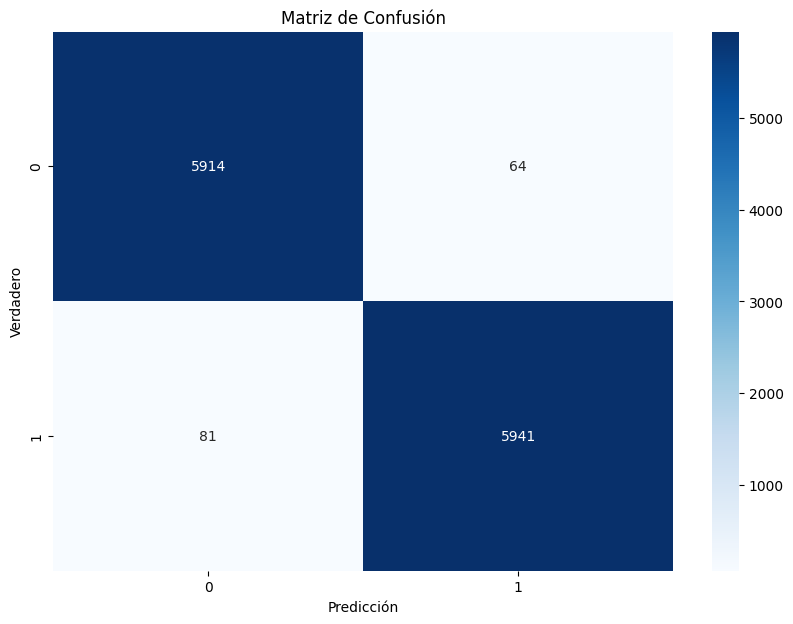

In [31]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=grid_search.classes_, yticklabels=grid_search.classes_)
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

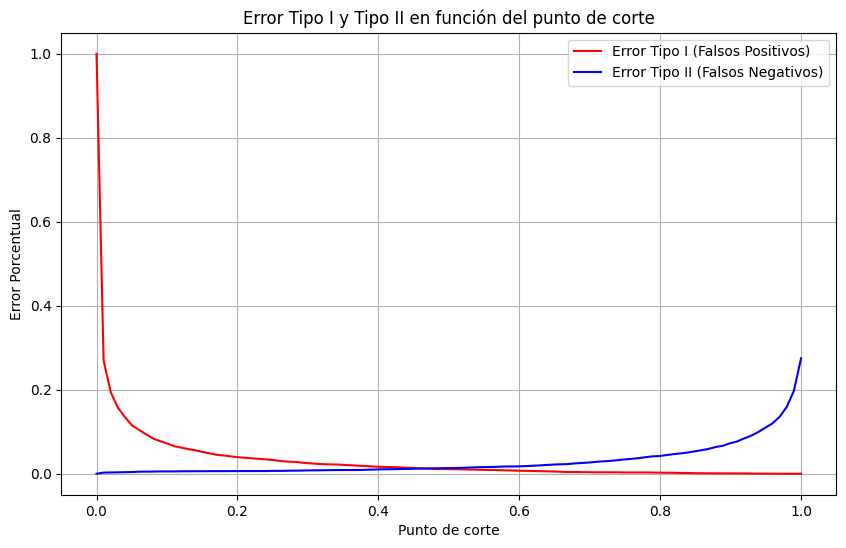

In [32]:


# Suponiendo que 'y_test' y 'y_pred_proba' están disponibles
# Asumiendo que el caso positivo está en la segunda columna de y_pred_proba
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Definir un rango de puntos de corte
thresholds = np.linspace(0, 1, 100)

# Inicializar listas para errores de Tipo I y Tipo II
type_i_errors = []
type_ii_errors = []

# Calcular errores para cada umbral
for thresh in thresholds:
    # Binarizar las predicciones según el punto de corte actual
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    
    # Calcular la matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    # Calcular el error de Tipo I (falsos positivos)
    type_i_error = fp / (fp + tn) if (fp + tn) != 0 else 0
    type_i_errors.append(type_i_error)
    
    # Calcular el error de Tipo II (falsos negativos)
    type_ii_error = fn / (fn + tp) if (fn + tp) != 0 else 0
    type_ii_errors.append(type_ii_error)

# Graficar los errores
plt.figure(figsize=(10, 6))
plt.plot(thresholds, type_i_errors, label='Error Tipo I (Falsos Positivos)', color='red')
plt.plot(thresholds, type_ii_errors, label='Error Tipo II (Falsos Negativos)', color='blue')
plt.title('Error Tipo I y Tipo II en función del punto de corte')
plt.xlabel('Punto de corte')
plt.ylabel('Error Porcentual')
plt.legend()
plt.grid(True)
plt.show()


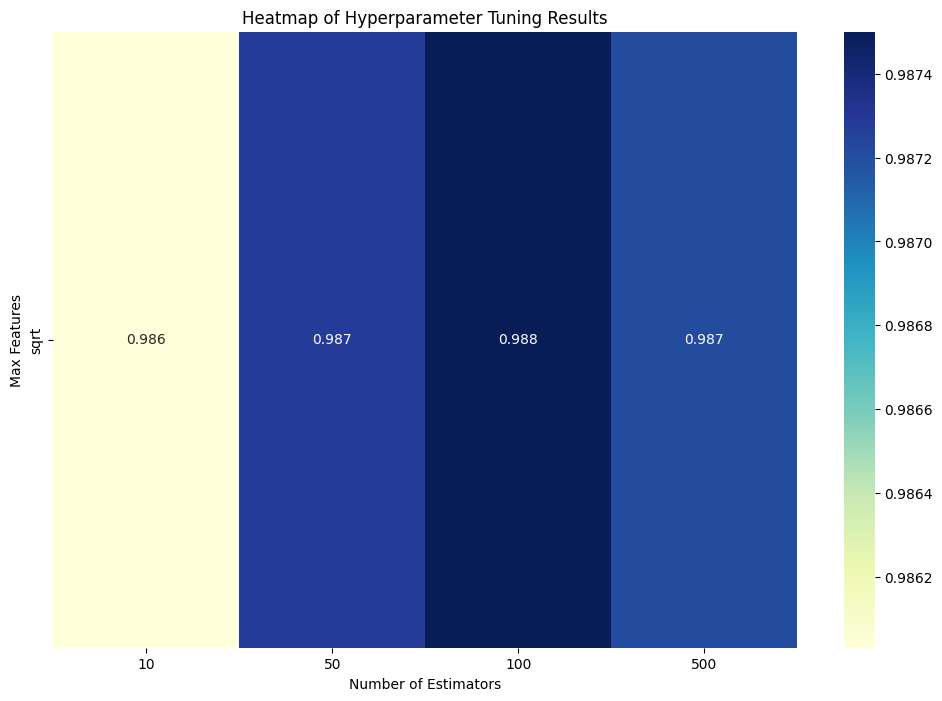

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Supongamos que ya tienes los resultados del GridSearchCV en grid_search

# Extraer los resultados de la búsqueda en una tabla
results = pd.DataFrame(grid_search.cv_results_)

# Filtrar solo las columnas relevantes
results = results[['param_max_depth', 'param_max_features', 'param_min_samples_leaf',
                   'param_min_samples_split', 'param_n_estimators', 'mean_test_score']]

# Pivotear los resultados para crear un heatmap
heatmap_data = results.pivot_table(index='param_max_features', columns='param_n_estimators', values='mean_test_score')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title('Heatmap of Hyperparameter Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Features')
plt.show()


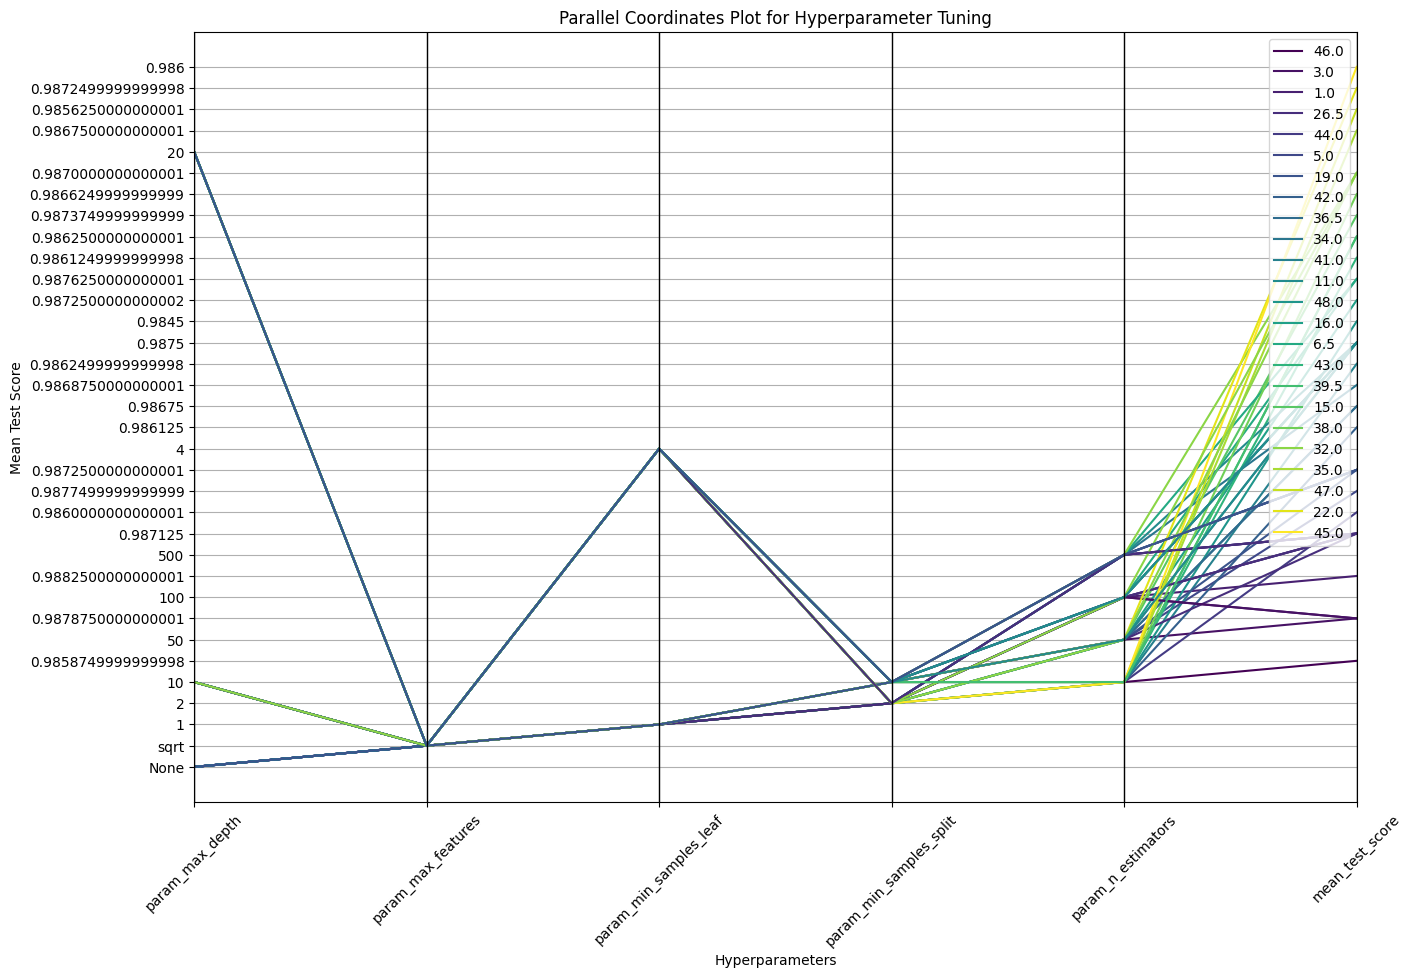

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Extraer los resultados de la búsqueda en una tabla
results = pd.DataFrame(grid_search.cv_results_)

# Filtrar solo las columnas relevantes
results = results[['param_max_depth', 'param_max_features', 'param_min_samples_leaf',
                   'param_min_samples_split', 'param_n_estimators', 'mean_test_score']]

# Convertir todos los valores de los hiperparámetros a cadenas de texto
results = results.astype(str)

# Añadir una columna de clasificación basada en el rendimiento
results['rank'] = results['mean_test_score'].astype(float).rank(ascending=False)

# Seleccionar un subconjunto de hiperparámetros y la métrica de rendimiento
selected_columns = ['param_max_depth', 'param_max_features', 'param_min_samples_leaf',
                    'param_min_samples_split', 'param_n_estimators', 'mean_test_score', 'rank']

# Crear el gráfico
plt.figure(figsize=(15, 10))
parallel_coordinates(results[selected_columns], class_column='rank', colormap='viridis')
plt.title('Parallel Coordinates Plot for Hyperparameter Tuning')
plt.xlabel('Hyperparameters')
plt.ylabel('Mean Test Score')
plt.xticks(rotation=45)
plt.show()


In [33]:
#path_modelos_finales="../modelos_finales"


In [34]:

#dump(grid_search.best_estimator_, path_modelos_finales+"/CLASE_II_IV_Random_forest.joblib")